In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = quandl.get('BCHARTS/BITFINEXUSD')

In [3]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2013-03-31,93.250000,100.000000,93.03000,93.100000,390.827224,3.708933e+04,94.899563
2013-04-01,93.170000,105.900000,92.49999,102.370000,4919.654127,4.921010e+05,100.027564
2013-04-02,102.800000,118.388067,99.00000,117.989990,9084.832816,9.874119e+05,108.687953
2013-04-03,116.579097,146.880000,101.51088,134.952969,12909.402178,1.652092e+06,127.975861
2013-04-04,131.779686,143.000000,119.00000,132.681000,6910.100414,9.094385e+05,131.610029


In [4]:
print(data.shape)
#1363,7

mean = data.mean(axis=0)
std = data.std(axis=0)

# zscore normalization
data = ( data - mean ) / std

# # of days past 
d = 15

X = np.zeros((1363,d,7))

# embedding d days in each DP (deslocamento)
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#removing first d lines, this ones didn't have d days past
X = X[d:,:,:]

print(X.shape)

(1363, 7)
(1348, 15, 7)


In [5]:
# criando as labels
Y = data['Weighted Price'] - data.shift(1)['Weighted Price']

Y.shape

(1363,)

In [6]:
Y = Y > 0

#retirando a primeira linha, pois a segunda label refere-se ao primeiro registro (variacao)
Y = Y[1:]

#retirando as d primeiras datas por causa do deslocamento
Y = Y[d:]

In [7]:
#retirando o ultimo registro das features para 
#especificando as outras dimensoes por boas praticas (nao esquecer a matriz)
X = X[: -1,:,:]

In [8]:
# checking shapes
Y.shape, X.shape

((1347,), (1347, 15, 7))

In [9]:
# passando pro formato de 4 dimensoes esperadas
X = X.reshape((Y.shape[0],d,7,1))

In [10]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# trying some cross validation
kf = KFold(n_splits=8,shuffle=True,random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)

In [26]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same pra nao reduzir 
    X = Conv2D(10,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(30,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    X = Conv2D(50,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn2')(X)
    X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(200,activation="relu")(X)
    X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(100,activation="relu")(X)
    X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(50,activation="relu")(X)
    X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [27]:
#instanciando modelo
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 300, batch_size = 8,verbose=1)

Epoch 1/300
1179/1179 [==============================] - 1s 1ms/step - loss: 0.7129 - acc: 0.5284
Epoch 2/300
1179/1179 [==============================] - 1s 788us/step - loss: 0.7026 - acc: 0.5064
Epoch 3/300
1179/1179 [==============================] - 1s 792us/step - loss: 0.6984 - acc: 0.5318
Epoch 4/300
1179/1179 [==============================] - 1s 852us/step - loss: 0.6963 - acc: 0.5284
Epoch 5/300
1179/1179 [==============================] - 1s 825us/step - loss: 0.6951 - acc: 0.5267
Epoch 6/300
1179/1179 [==============================] - 1s 863us/step - loss: 0.6888 - acc: 0.5505
Epoch 7/300
1179/1179 [==============================] - 1s 1ms/step - loss: 0.6890 - acc: 0.5488
Epoch 8/300
1179/1179 [==============================] - 1s 779us/step - loss: 0.6897 - acc: 0.5420
Epoch 9/300
1179/1179 [==============================] - 1s 926us/step - loss: 0.6860 - acc: 0.5462
Epoch 10/300
1179/1179 [==============================] - 1s 990us/step - loss: 0.6821 - acc: 0.5488
Epo

1179/1179 [==============================] - 1s 836us/step - loss: 0.3066 - acc: 0.8550
Epoch 84/300
1179/1179 [==============================] - 1s 1ms/step - loss: 0.3050 - acc: 0.8372
Epoch 85/300
1179/1179 [==============================] - 1s 850us/step - loss: 0.2696 - acc: 0.8711
Epoch 86/300
1179/1179 [==============================] - 1s 834us/step - loss: 0.2792 - acc: 0.8567
Epoch 87/300
1179/1179 [==============================] - 1s 887us/step - loss: 0.3058 - acc: 0.8473
Epoch 88/300
1179/1179 [==============================] - 1s 832us/step - loss: 0.3222 - acc: 0.8465
Epoch 89/300
1179/1179 [==============================] - 1s 807us/step - loss: 0.2849 - acc: 0.8601
Epoch 90/300
1179/1179 [==============================] - 1s 882us/step - loss: 0.2626 - acc: 0.8753
Epoch 91/300
1179/1179 [==============================] - 1s 1ms/step - loss: 0.2804 - acc: 0.8617
Epoch 92/300
1179/1179 [==============================] - 1s 946us/step - loss: 0.2932 - acc: 0.8575
Epoch 9

1179/1179 [==============================] - 2s 2ms/step - loss: 0.1927 - acc: 0.9126
Epoch 165/300
1179/1179 [==============================] - 2s 2ms/step - loss: 0.1490 - acc: 0.9211
Epoch 166/300
1179/1179 [==============================] - 2s 2ms/step - loss: 0.1765 - acc: 0.9177
Epoch 167/300
1179/1179 [==============================] - 2s 2ms/step - loss: 0.2302 - acc: 0.8957
Epoch 168/300
1179/1179 [==============================] - 2s 2ms/step - loss: 0.1869 - acc: 0.9135
Epoch 169/300
1179/1179 [==============================] - 2s 2ms/step - loss: 0.1958 - acc: 0.9109
Epoch 170/300
1179/1179 [==============================] - 2s 1ms/step - loss: 0.1713 - acc: 0.9084
Epoch 171/300
1179/1179 [==============================] - 2s 2ms/step - loss: 0.1623 - acc: 0.9160
Epoch 172/300
1179/1179 [==============================] - 2s 2ms/step - loss: 0.2128 - acc: 0.9025
Epoch 173/300
1179/1179 [==============================] - 2s 2ms/step - loss: 0.1480 - acc: 0.9254
Epoch 174/300


1179/1179 [==============================] - 1s 996us/step - loss: 0.1263 - acc: 0.9457
Epoch 246/300
1179/1179 [==============================] - 1s 1ms/step - loss: 0.1446 - acc: 0.9296
Epoch 247/300
1179/1179 [==============================] - 1s 918us/step - loss: 0.1303 - acc: 0.9423
Epoch 248/300
1179/1179 [==============================] - 1s 892us/step - loss: 0.1103 - acc: 0.9474
Epoch 249/300
1179/1179 [==============================] - 1s 928us/step - loss: 0.1194 - acc: 0.9500
Epoch 250/300
1179/1179 [==============================] - 1s 825us/step - loss: 0.1180 - acc: 0.9500
Epoch 251/300
1179/1179 [==============================] - 1s 1ms/step - loss: 0.1502 - acc: 0.9271
Epoch 252/300
1179/1179 [==============================] - 1s 993us/step - loss: 0.1393 - acc: 0.9389
Epoch 253/300
1179/1179 [==============================] - 1s 907us/step - loss: 0.1616 - acc: 0.9313
Epoch 254/300
1179/1179 [==============================] - 2s 1ms/step - loss: 0.1471 - acc: 0.9355


In [29]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

168/168 [==============================] - 0s 539us/step

Loss = 3.31891363008
Acc = 0.553571428571


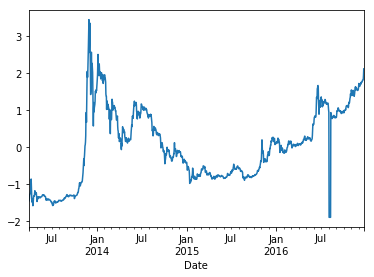

In [14]:
data['Weighted Price'].plot()